# Blocks to points Ordinary Kriging interpolation - tutorial

## Table of Contents:

1. Read areal data,
2. Detect and remove outliers,
3. Create semivariogram model,
4. Read point data canvas,
5. Build map of interpolated values,
6. Show map of interpolated values with choropleth map of breast cancer rates.

## Level: Intermediate

## Introduction

This tutorial is based on the question of user *@ikey* from *Discord* channel of package (02/04/2021). Thank you *@ikey* for it!

In short:

> Are we able to perform Semivariogram Regularization and Poisson Kriging if our point support represents only points without any values?

**No, it's not possible**. But there is a hack which we can use - we are able to interpolate missing values from areal centroids with Ordinary and Simple Kriging just like we do it with *regular points*. Why is it not possible with unknown points?

The idea behind semivariogram regularization of areal aggregates is to use semivariogram of points (values). And not any points, they must reflect ongoing process. As example, in the case of epidemiology:

1. We have areal counts of infections divided by POPULATION over some area.
2. We take POPULATION blocks (points) with number of inhabitants per block and use those as a support of our map. Thus we transform choropleth map into point map, and only to the points, where someone is living ==> someone may be infected. We skip large parts of map where risk of infection is not present because no one is living there.
3. And we finally obtain population-at-risk map of points or smoothed choropleth map of infection risk without large visual bias where large/small areas seems to be more important.

This works when we have specific **counts over area divided by other parameter** (time, population, probability, volume etc.). In this scenario we can find function which links our areal counts with those underlying variables and/or processes. Without support values we are not able to perform semivariogram regularization.

What we want to achieve may be done with Ordinary Kriging (because our points are really unknown) and semivariogram regularization is not required (and not possible without any values).

In summary we will learn how to:

- transform areal data into points,
- detect and remove outliers from data,
- create interpolated map from unknown points,
- visualize and save created map.

We use: 

- for point canvas: `sample_data/point_data/`,
- for areal centroids: Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/breast_cancer_rate_per_area_2.shp`.

This tutorial requires understanding of concepts presented in **Semivariogram Estimation** and **Variogram Point Cloud** tutorials along with **Ordinary and Simple Kriging** notebook and (optionally) **Semivariogram Regularization** tutorial.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from pyinterpolate.io_ops import prepare_areal_shapefile
from pyinterpolate.semivariance import build_variogram_point_cloud, show_variogram_cloud, remove_outliers
from pyinterpolate.semivariance import calc_semivariance_from_pt_cloud
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import Krige

## 1) Read areal data

In [2]:
areal = '../sample_data/areal_data/breast_cancer_rate_per_area_2.shp'
id_col = 'id'
val_col = 'rate'
dataset = prepare_areal_shapefile(areal, id_column_name=id_col, value_column_name=val_col)
dataset[0]

array([0, <shapely.geometry.polygon.Polygon object at 0x7f94dec14f50>,
       -76.51541607859876, 41.78864564848121, 129.0], dtype=object)

In [3]:
data_centroids = dataset[:, -3:]
data_centroids[0]

array([-76.51541607859876, 41.78864564848121, 129.0], dtype=object)

### Clarification:

Prepared areal shapefile has five columns: ```[area id, geometry, centroid x, centroid y, value]```. We don't need polygons' geometry and areas' id in the case of point kriging. Prepared array is sliced and in return we get array of centroids and their values. This is our base for modeling.

## 2) Detect and remove outliers

We check and clean data before semivariogram fit and Ordinary Kriging. Variogram Point Cloud is the best way to analyze data and detect outliers which may affect further analysis. We check and compare few different lags and step sizes and their respective point clouds. Then we will use those different number of ranges to create multiple semivariogram and Kriging models.

In [4]:
# Create analysis parameters

maximum_range = 4

number_of_lags = [4, 8, 16]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    variogram_cloud = build_variogram_point_cloud(data_centroids, step_size, maximum_range)
    variogram_clouds.append(variogram_cloud)

Lags per area: 4



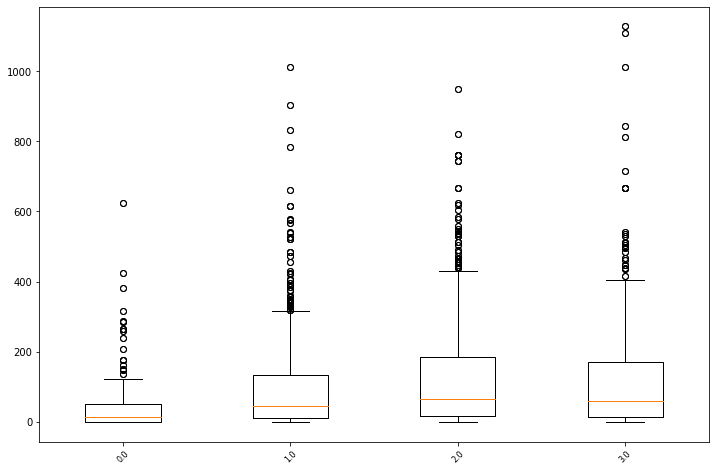


###########

Lags per area: 8



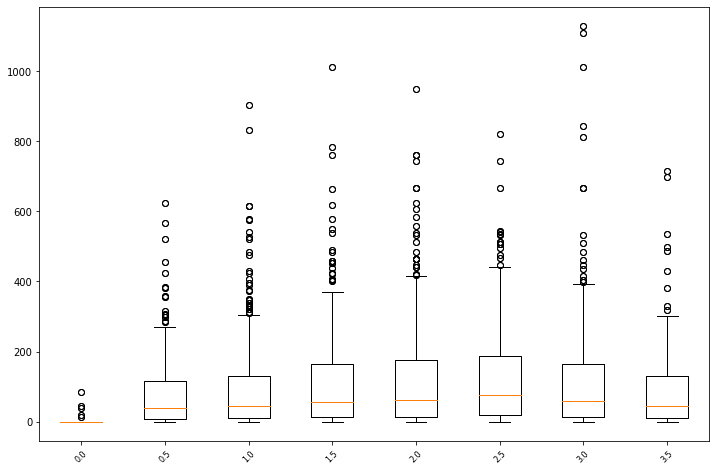


###########

Lags per area: 16



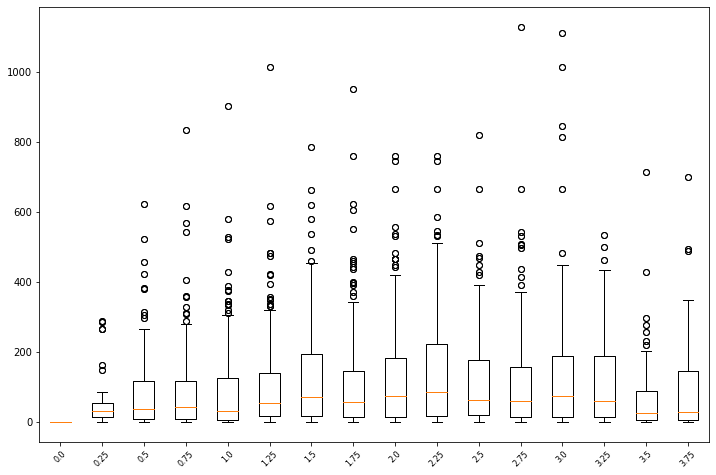


###########



In [5]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = variogram_clouds[idx]
    show_variogram_cloud(var_cloud, figsize=(12, 8))
    
    print('\n###########\n')

In [6]:
# Now remove outliers from each lag

clouds_without_outliers = [remove_outliers(x) for x in variogram_clouds]

Lags per area: 4



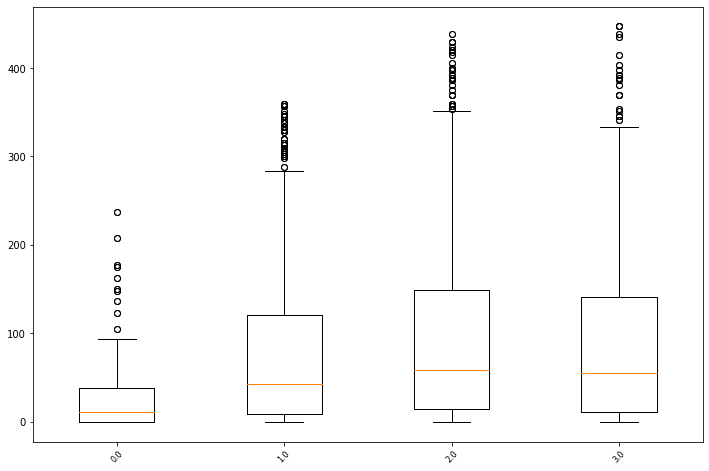


###########

Lags per area: 8



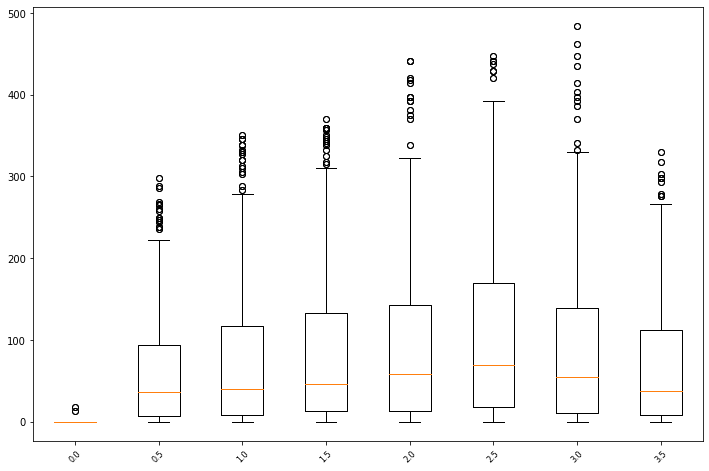


###########

Lags per area: 16



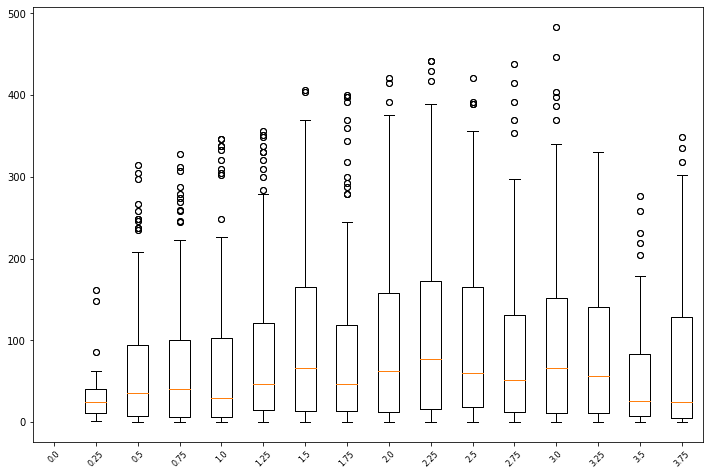


###########



In [7]:
# And show data without outliers

for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = clouds_without_outliers[idx]
    show_variogram_cloud(var_cloud, figsize=(12, 8))
    
    print('\n###########\n')

### Clarification:

It could be not visible, but we got rid off outliers from dataset. Look into **y** axes of variogram clouds with and without outliers for each lag. You hopefully see that maximum values after data cleaning are two times smaller. We can test different lags now to create semivariogram models.

## 3. Create semivariogram model

Semivariogram may be fitted manually or automatically. In this case we fit it automatically - we test multiple models and it's easier to use ```find_optimal_model()``` method of ```TheoreticalSemivariogram``` object.

In [8]:
theoretical_semivariograms = []

for idx, cloud_model in enumerate(clouds_without_outliers):
    
    print(f'Semivariance calculated for {number_of_lags[idx]} lag')
    print('')
    # Calculate experimental model
    exp_model = calc_semivariance_from_pt_cloud(cloud_model)
    
    # Assign experimental model and data to TheoreticalSemivariogram
    theo_semi = TheoreticalSemivariogram(points_array=data_centroids,
                                         empirical_semivariance=exp_model,
                                         verbose=True)
    theo_semi.find_optimal_model(weighted=False, number_of_ranges=number_of_lags[idx])
    theoretical_semivariograms.append(theo_semi)
    print('')
    print('Model parameters:')
    print('Nugget:', theo_semi.params[0])
    print('Sill:', theo_semi.params[1])
    print('Range:', theo_semi.params[2])
    print('')
    print('#####')

Semivariance calculated for 4 lag

Model: spherical, error value: 31.15757982076438
Model: exponential, error value: 7.4494298829248
Model: linear, error value: 14.233317321968858
Chosen model: exponential, with value: 7.4494298829248.

Model parameters:
Nugget: 30.495941422594136
Sill: 105.32523501893516
Range: 2.333333333333333

#####
Semivariance calculated for 8 lag

Model: spherical, error value: 15.75283487033229
Model: exponential, error value: 9.310688498335388
Model: linear, error value: 12.641849524533907
Chosen model: exponential, with value: 9.310688498335388.

Model parameters:
Nugget: 0.8733802816901399
Sill: 105.32523501893516
Range: 0.9285714285714286

#####
Semivariance calculated for 16 lag

Model: spherical, error value: 17.989666805169772
Model: exponential, error value: 11.117560665767424
Model: linear, error value: 14.25431385484735
Chosen model: exponential, with value: 11.117560665767424.

Model parameters:
Nugget: 0.0
Sill: 105.32523501893516
Range: 0.716666666

/home/szymon/anaconda3/envs/pyintpk/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


### Clarification:

_Exponential_ model was chosen in each case. This model offers lowest error of fitting. If we look only into the error value then we may assume that the best model is for 4 lags... but when we compare different parameters of semivariogram model we see interesting things.

**Nugget** of four lags is large and it's 30 cases per 100,000 inhabitants. Why is that? Model with only four lags catches large distance near the zero origin and it introduces bias. Other lags have nugget close to 0.

**Range** of the first model is very large compared to the areal bounds and it is a half of them. Range of 8 and 16 lags is closer to each other and more than two-three times smaller than range of 4 lags. It's the same effect of large spacing for 4 lags.

**Sill** is the same because it describes variance in dataset (which is constant).

Summarizing: 4-lags model has lowest error of fit but largest nugget and range. 8- and 16-lags models have comparable nugget and range. Probably one of these models will be a better fit for Kriging. 

## 4. Read point data canvas

**Pyinterpolate** doesn't have function for read point data directly from shapefile (2021-02-07) but we can do it with **GeoPandas** package. **Pyinterpolate** uses **GeoPandas** under the hood so there is no problem with import of this package.

We read point file as the **GeoDataFrame** object which stores geometry column and data features as tables.

In [9]:
points = '../sample_data/point_data/regular_grid_points.shp'  # file with grid for analysis
gdf_pts = gpd.read_file(points)
gdf_pts.set_index('id', inplace=True)
gdf_pts.head()

,geometry
id,
36,POINT (-80.17456 42.09693)
37,POINT (-80.00214 42.09693)
38,POINT (-79.82973 42.09693)
69,POINT (-80.34697 41.92452)
70,POINT (-80.17456 41.92452)


Now we interpolate value for each point with Kriging. We use ```apply()``` on geometry column and create new columns of *GeoDataFrame* with interpolated results.

## 5. Build map of interpolated values

In [10]:
# Set kriging models

def krige_point(pt, k_model, no_of_neighbors=8):
    """
    Function predicts value at unknown location with 8 closest neighbors and given kriging model.
    
    INPUT:
    
    :param pt: (shapely Point),
    :param k_model: (Krige),
    :param no_of_neighbors: (int)
    
    OUTPUT:
    
    :return: (float)
    """
    val = k_model.ordinary_kriging(unknown_location=[pt.x, pt.y], number_of_neighbours=no_of_neighbors)
    return pd.Series([val[0], val[1]])

kriging_models = []
for idx, semi_model in enumerate(theoretical_semivariograms):
    kriging_model = Krige(semivariogram_model=semi_model, known_points=data_centroids)
    col_name = 'lags_' + str(number_of_lags[idx])
    err_col_name = 'e_' + col_name
    
    # Interpolate missing values and uncertainty
    gdf_pts[[col_name, err_col_name]] = gdf_pts.geometry.apply(krige_point, args=[kriging_model])
    
    # Append model
    kriging_models.append(kriging_model)

In [11]:
gdf_pts.head()

,geometry,lags_4,e_lags_4,lags_8,e_lags_8,lags_16,e_lags_16
id,,,,,,,
36,POINT (-80.17456 42.09693),133.904033,5.693619,133.519242,3.889163,133.351873,4.186358
37,POINT (-80.00214 42.09693),135.090127,5.730284,134.714839,3.346946,134.541776,3.600123
38,POINT (-79.82973 42.09693),135.065053,5.475582,134.755498,4.077638,134.589831,4.395521
69,POINT (-80.34697 41.92452),130.991095,4.852128,130.810558,3.916190,130.723980,4.185127
70,POINT (-80.17456 41.92452),131.671928,4.947055,131.795708,3.304024,131.835774,3.585157


### Clarification:

This is rather complicated function in which we interpolated missing values as a new columns of **GeoDataFrame**. *Uncertainty* was assigned with interpolated results for further analysis.

Now we can save our **GeoDataFrame** as a shapefile...

In [12]:
# Save interpolation results

gdf_pts.to_file('interpolation_results_areal_to_point.shp')

or check results directly in a notebook!

## 6. Show map of interpolated values with choropleth map of breast cancer rates

In [13]:
# First read areal shapefile

gdf = gpd.read_file(areal)
gdf.head()

,name,rate,id,geometry
0,bradford,129.0,0,"POLYGON ((-76.14569 41.99885, -76.14364 41.977..."
1,bucks,140.9,1,"POLYGON ((-75.19130 40.58570, -75.19156 40.585..."
2,tioga,127.4,2,"POLYGON ((-77.17156 41.99967, -77.16142 41.999..."
3,union,118.0,3,"POLYGON ((-76.91306 40.88454, -76.91356 40.884..."
4,venango,126.0,4,"POLYGON ((-79.98155 41.51290, -79.98149 41.512..."


Lag 4


<Figure size 432x288 with 0 Axes>

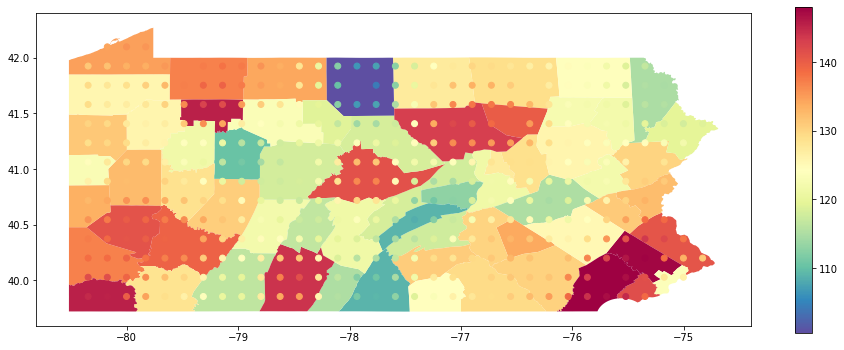

######
Lag 8


<Figure size 432x288 with 0 Axes>

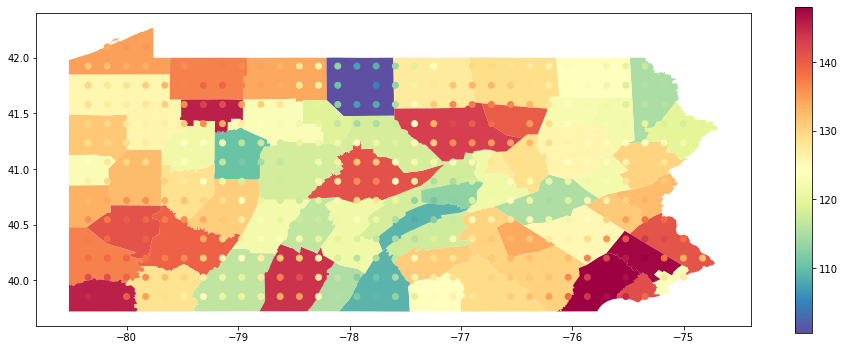

######
Lag 16


<Figure size 432x288 with 0 Axes>

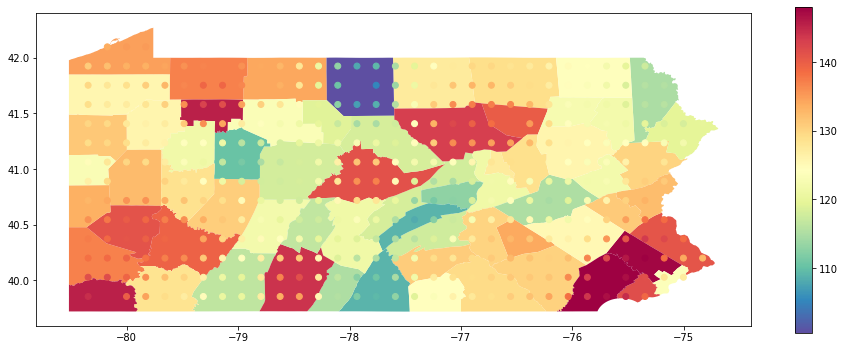

######


In [14]:
# Now compare results to choropleth maps

fs = (16, 6)

for lag in number_of_lags:
    print('Lag', lag)
    col_name = 'lags_' + str(lag)
    plt.figure()
    base = gdf.plot(figsize=fs, column='rate', cmap='Spectral_r', legend=True)
    gdf_pts.plot(ax=base, column=col_name, cmap='Spectral_r')
    plt.show()
    print('######')

### Clarification:

Visual inspection shows two things:

1. Interpolated results are more smoothed over area and in the most part of a map they are similar to the rate observed in specific county.
2. Difference between interpolated points is not visible. Is there any?

To answer that last question we calculate Mean Absolute Difference between each lag's interpolated results.

In [15]:
for lag1 in number_of_lags:
    print('LAG:', lag1)
    col_name1 = 'lags_' + str(lag1)
    for lag2 in number_of_lags:
        if lag1 == lag2:
            pass
        else:
            col_name2 = 'lags_' + str(lag2)
            mad = gdf_pts[col_name1] - gdf_pts[col_name2]
            mad = np.abs(np.mean(mad))
            print('')
            print(f'Mean Absolute Difference between lag {lag1} and lag {lag2} is {mad:.6f}')
            print('')

LAG: 4

Mean Absolute Difference between lag 4 and lag 8 is 0.007541


Mean Absolute Difference between lag 4 and lag 16 is 0.013055

LAG: 8

Mean Absolute Difference between lag 8 and lag 4 is 0.007541


Mean Absolute Difference between lag 8 and lag 16 is 0.005514

LAG: 16

Mean Absolute Difference between lag 16 and lag 4 is 0.013055


Mean Absolute Difference between lag 16 and lag 8 is 0.005514



### Clarification:

As you see those differences are really small. Each semivariogram model is similar in this case.

#### NOTE:

If you want to tune Kriging model it is better to test different number of neighbors on your model.

---